In [ ]:
# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [3]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='.//datasets//mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000L, 784L)
label shape: (70000L,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

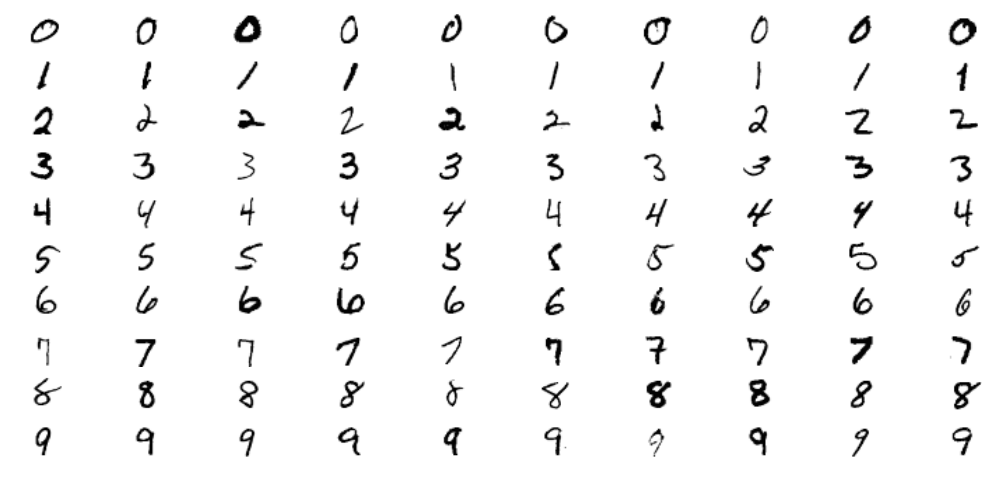

In [274]:
def P1(num_examples=10):
    '''Function that generates the given number of image samples for each
    single digit number in the MNIST dataset.'''

# Randomly sample from all the images with a given label n times with n equal
# to the number of examples
    image_samples = []
    for i in range(10):
        nums = [n for n in range(len(Y)) if Y[n] == i]
        for i in range(num_examples):
            image_samples.append(X[np.random.choice(nums)])

    # Plot each image in a n x n grid where n is the number of examples
    fig = plt.figure(figsize=(18, 8))
    for img in range(len(image_samples)):
        plt.subplot(10, num_examples, img+1)
        plt.axis('off')
        plt.imshow(image_samples[img].reshape(28, 28), cmap='Greys')
    return
P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [4]:
def P2(k_values):
    '''Function that produces k nearest neighbor classifcation with n
    neighbors for each n in the input list. Reports accuracy
    of predictions on the development dataset'''
    for i in k_values:
        neigh = KNeighborsClassifier(n_neighbors=i)
        neigh.fit(mini_train_data, mini_train_labels)
        preds = neigh.predict(dev_data)
        correct, total = 0, 0
        for pred, label in zip(preds, dev_labels):
            if pred == label:
                correct += 1
            total += 1
        print('total: {} correct: {} accuracy for {} neighbor(s): {}'.format(
            total, correct, i, 1.0*correct/total))
        if i == 1:
            # Print classification report of 1 neighbor classification
            print(classification_report(dev_labels, preds, range(10)))
    return
k_values = [1, 3, 5, 7, 9]
P2(k_values)

total: 1000 correct: 888 accuracy for 1 neighbor(s): 0.888
             precision    recall  f1-score   support

          0       0.91      0.98      0.94        99
          1       0.89      1.00      0.94       105
          2       0.99      0.79      0.88       102
          3       0.77      0.87      0.82        86
          4       0.89      0.82      0.85       104
          5       0.93      0.84      0.88        91
          6       0.94      0.96      0.95        98
          7       0.89      0.92      0.90       113
          8       0.94      0.88      0.91        96
          9       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000

total: 1000 correct: 878 accuracy for 3 neighbor(s): 0.878
total: 1000 correct: 869 accuracy for 5 neighbor(s): 0.869
total: 1000 correct: 865 accuracy for 7 neighbor(s): 0.865
total: 1000 correct: 863 accuracy for 9 neighbor(s): 0.863


ANSWER: The digit '3' was the most difficult to correctly classify as measured by the F-1 score.

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [5]:
def P3(train_sizes):
    '''Function that takes a list of integers as input. Runs 
    1-NN classification for each integer in the list. Outputs 
    the accuracy of each classification and how long it took
    to run.'''
    accuracies = []
    times = []
    for i in train_sizes:
        #Run 1-NN
        neigh = KNeighborsClassifier(n_neighbors=1)
        data = np.random.choice(np.arange(60000), i)
        sample_data = [train_data[i] for i in data]
        sample_labels = [train_labels[i] for i in data]
        #Note start time
        start_time =  time.time()
        neigh.fit(sample_data, sample_labels)
        preds = neigh.predict(dev_data)
        #Note end time
        end_time = time.time()
        times.append(round(end_time - start_time, 3))
        del start_time, end_time, data
        #Calculate accuracy
        correct, total = 0, 0
        for pred, label in zip(preds, dev_labels):
            if pred == label: correct += 1
            total += 1
        accuracies.append(1.0*correct/total)
    return zip(train_sizes, accuracies, times)

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
trial_output = P3(train_sizes)
#Report accuracy and time for each trial.
for size, accuracy, p_time in trial_output:
    print(
        'A training size of {} had accuracy of {}'
        ' And took {} seconds to process'.format(
        size, accuracy, p_time))

A training size of 100 had accuracy of 0.714 And took 0.087 seconds to process
A training size of 200 had accuracy of 0.771 And took 0.169 seconds to process
A training size of 400 had accuracy of 0.827 And took 0.336 seconds to process
A training size of 800 had accuracy of 0.892 And took 0.678 seconds to process
A training size of 1600 had accuracy of 0.904 And took 1.419 seconds to process
A training size of 3200 had accuracy of 0.926 And took 2.907 seconds to process
A training size of 6400 had accuracy of 0.941 And took 5.953 seconds to process
A training size of 12800 had accuracy of 0.955 And took 12.318 seconds to process
A training size of 25000 had accuracy of 0.962 And took 25.73 seconds to process


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [6]:
def P4(data):
    '''Function that runs linear regression using the input
    list of integers from P3 and the output list of 
    accuracies. Uses the model to predict for a larger
    training dataset.'''
    #Format data for regression in sklearn
    X_1 = np.array([x[0] for x in data]).reshape(-1,1)
    Y_1 = np.array([x[1] for x in data]).reshape(-1,1)
    #Fit regression model
    lm = LinearRegression()
    lm.fit(X_1, Y_1)
    #Report results
    print('Coefficient for accuracy: {0:.3g}'.format(lm.coef_[0][0]))
    #Report predicted value for large training set. 
    print('Prediction for training size of 60000: {0:.3g}'.format(lm.predict(60000)[0][0]))
    print('R-squared value: {0:.3g}'.format(lm.score(X_1, Y_1)))
    return
data = P3([100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000])
P4(data)

Coefficient for accuracy: 7.01e-06
Prediction for training size of 60000: 1.25
R-squared value: 0.402


In [7]:
def P4b(data):
    '''Aternative function that run linear regression using
    the natural log of the input list of integers from P3 and
    the output list of accuracies. Extends the training data sets
    to include observations closer to the predicted value.'''
    #Format and transform data for regression in sklear
    X_1 = np.array([np.log(x[0]) for x in data]).reshape(-1,1)
    Y_1 = np.array([x[1] for x in data]).reshape(-1,1)
    #Fit regression model 
    lm = LinearRegression()
    lm.fit(X_1, Y_1)
    #Report results
    print('Coefficient for accuracy: {0:.3g}'.format(lm.coef_[0][0]))
    #Report predicted value for large training set. 
    print('Prediction for training size of 60000: {0:.3g}'.format(lm.predict(np.log(60000))[0][0]))
    print('R-squared value: {0:.3g}'.format(lm.score(X_1, Y_1)))
    return
data1 = P3([100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000, 50000])
P4b(data1)

Coefficient for accuracy: 0.0391
Prediction for training size of 60000: 1.01
R-squared value: 0.915


ANSWER: Linear regression is limited by the fact that the relationship between accuracy and sample size is non linear. Despite the fact that we know that the outcome variable cannot be greater than one, making linear predictions outside the range of training values will always result in the possibility of making nonsense predictions. One way to make the values more reasonable is to use a log transformation of the x variable and to train the model with values closer to the range for which prediction is desired. While accuracies can still go over 1 for predictions outside the range of the training data, they are closer to the actual range of possible values. 

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

[[ 97   0   4   1   0   2   1   1   0   1]
 [  0 105   4   0   2   0   1   4   2   0]
 [  0   0  81   0   0   0   1   0   0   0]
 [  0   0   4  75   0   9   0   1   5   3]
 [  0   0   0   0  85   0   1   1   0   9]
 [  0   0   0   3   0  76   0   0   2   1]
 [  2   0   0   0   3   0  94   0   1   0]
 [  0   0   4   3   0   1   0 104   0   5]
 [  0   0   3   1   0   1   0   0  84   0]
 [  0   0   2   3  14   2   0   2   2  87]]

The most confused digit pair was 4 and 9, with 14 mistakes.


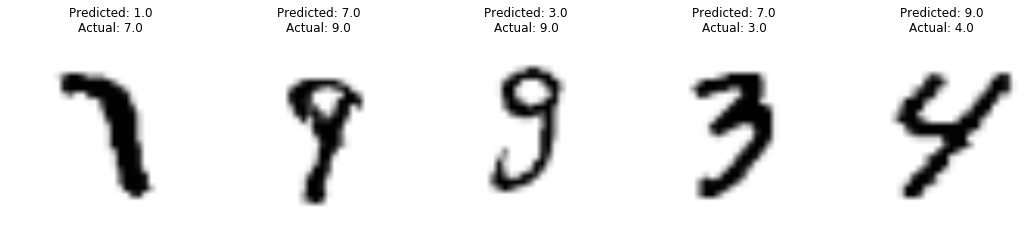

In [8]:
def P5():
    '''Function that ouputs a confusion matrix
    for the mini_train_data. Finds the values that
    are most commmonly mistaken and prints 5
    examples of mistaken data points.'''
    #Classify 1-NN
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(mini_train_data, mini_train_labels)
    preds = neigh.predict(dev_data)
    M = confusion_matrix(preds, dev_labels)
    #Output confusion matrix
    print(M)
    #Find highest value in non-daigonal row (most confused)
    np.fill_diagonal(M, 0)
    most_confused = np.amax(M)
    #Find indexes where most confused values are
    indexes = np.where(M == most_confused)
    #Randomly select 5 examples of mistaken classification
    c = [i for i in range(len(dev_labels)) if dev_labels[i] != preds[i]]
    mistakes = np.random.choice(c,5)
    fig = plt.figure(figsize=(18, 8))
    #Plot the examples
    for img in range(len(mistakes)):
        plt.subplot(1, 5, img+1)
        plt.axis('off')
        plt.imshow(dev_data[mistakes[img]].reshape(28, 28), cmap='Greys')
        plt.title('Predicted: {}\nActual: {}'.format(preds[mistakes[img]],dev_labels[mistakes[img]]))
    #  Report the most confused digit pair. 
    print('\nThe most confused digit pair was {} and {}, with {} mistakes.'.format(
            indexes[1][0], indexes[0][0], most_confused))
    return
P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [169]:
# Note, I'd love to see a better way of doing this. 
def simpleBlur(ndarray):
    '''Function that takes a 1000 x 784 x 1 input array and transforms
    each element to a square matrix. Outputs a new 1000 x 28 x 28 array
    where each value in a matrix is the weighted average of the original 
    value and it\'s neighboring values.'''
    #Reshape the array
    A = np.array([ndarray[i].reshape(28,28) for i in range(len(ndarray))])
    #Make empty output array
    Z = np.empty([A.shape[0], A.shape[1], A.shape[2]])
    # Initialize a counter
    count = 0
    # Go through the component 28 x 28 matrices
    # of the input array
    for a in A:
        '''The idea here is to handle all corners and sides
        as unique cases and calculate the approriate number of
        neighboring weights. If a cell is not an edge case, all
        8 neighboring values are calculated.'''
        n = 28
        z = np.zeros(n*n).reshape(n,n)
        for i in range(n):
            for j in range(n):
                vals = []
                tot = 0
                vals.append(a[i,j])
                tot += 1
                #Lower right corner
                if (i+1 == n and j + 1 == n):
                    vals.append(a[i-1, j-1])
                    vals.append(a[i-1, j])
                    vals.append(a[i, j-1])
                    tot += 3
                #Upper left corner
                elif (i-1 <0 and j -1 <0):
                    vals.append(a[i+1, j+1])
                    vals.append(a[i+1, j])
                    vals.append(a[i, j+1])
                    tot += 3
                #Lower left corner
                elif (i+1 == n and j -1 < 0):
                    vals.append(a[i, j+1])
                    vals.append(a[i-1, j])
                    vals.append(a[i-1, j+1])
                    tot +=3
                #Upper right corner
                elif (i -1 < 0 and j+1 == n):
                    vals.append(a[i, j-1])
                    vals.append(a[i+1, j])
                    vals.append(a[i+1, j-1])
                    tot += 3
                #Left side non corner rows
                elif (0 < i <n-1 and j == 0):
                    vals.append(a[i, j+1])
                    vals.append(a[i + 1, j])
                    vals.append(a[i + 1, j + 1])
                    vals.append(a[i-1, j])
                    vals.append(a[i-1, j + 1])
                    tot += 5
                #Right side non corner rows
                elif (0 < i <n-1 and j+1 == n):
                    vals.append(a[i, j-1])
                    vals.append(a[i + 1, j])
                    vals.append(a[i + 1, j - 1])
                    vals.append(a[i-1, j])
                    vals.append(a[i-1, j - 1])
                    tot += 5
                #Lower non corner rows
                elif (i+1 == n and 0 < j < n-1):
                    vals.append(a[i, j-1])
                    vals.append(a[i, j+1])
                    vals.append(a[i-1, j-1])
                    vals.append(a[i-1, j])
                    vals.append(a[i-1, j+1])
                    tot += 5
                #Upper non corner rows
                elif (i == 0 and 0 < j < n-1):
                    vals.append(a[i, j-1])
                    vals.append(a[i, j+1])
                    vals.append(a[i+1, j-1])
                    vals.append(a[i+1, j])
                    vals.append(a[i+1, j+1])
                    tot += 5
                #Non edge rows and columns
                elif (0 < i <n-1 and 0 < j < n-1):
                    vals.append(a[i -1,j -1])
                    vals.append(a[i-1, j])
                    vals.append(a[i, j-1])
                    vals.append(a[i + 1, j + 1])
                    vals.append(a[i + 1, j])
                    vals.append(a[i, j+1])
                    vals.append(a[i+1, j -1])
                    vals.append(a[i -1, j + 1])
                    tot += 8
                #Set the value at z[i,j] to the
                # weighted average a[i,j] and
                # all it's neighboring cells.
                z[i,j] = sum(vals)*1.0/tot
        #Replace the empty array with the calculated
        #Weighted array z.
        Z[count] = z
        #increment the count
        count +=1
    return Z
def P6():
    '''Function that calculates 1-NN using
    1. Blurred training data and un-processed testing data
    2. Un-procesed training data and blurred testing data
    3. Blurred training and testing data.'''
    blur_train = simpleBlur(mini_train_data)
    blur_dev = simpleBlur(dev_data)
    #1-NN for blurred training data
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(blur_train.reshape(1000, 784), mini_train_labels)
    preds = neigh.predict(dev_data)
    correct, total = 0,0
    # Output accuracy
    for pred, label in zip(preds, dev_labels):
        if pred == label: correct +=1
        total += 1
    print('Results for pre-processed training data and unprocessed test data')
    print('total: {} correct: {} accuracy: {}'.format(total, correct, 1.0*correct/total))
    #1-NN for blurred testing data
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(mini_train_data, mini_train_labels)
    preds = neigh.predict(blur_dev.reshape(1000, 784))
    correct, total = 0,0
    # Output accuracy
    for pred, label in zip(preds, dev_labels):
        if pred == label: correct +=1
        total += 1
    print('Results for unprocessed training data and pre-processed test data')
    print('total: {} correct: {} accuracy: {}'.format(total, correct, 1.0*correct/total))
    #1-NN for blurred training and testing data
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(blur_train.reshape(1000, 784), mini_train_labels)
    preds = neigh.predict(blur_dev.reshape(1000, 784))
    correct, total = 0,0
    # Output accuracy
    for pred, label in zip(preds, dev_labels):
        if pred == label: correct +=1
        total += 1
    print('Results for pre-processed training data and pre-processed test data')
    print('total: {} correct: {} accuracy: {}'.format(total, correct, 1.0*correct/total))
    return
P6()

Results for pre-processed training data and unprocessed test data
total: 1000 correct: 908 accuracy: 0.908
Results for unprocessed training data and pre-processed test data
total: 1000 correct: 871 accuracy: 0.871
Results for pre-processed training data and pre-processed test data
total: 1000 correct: 902 accuracy: 0.902


ANSWER:

Results for pre-processed training data and unprocessed test data
total: 1000 correct: 908 accuracy: 0.908

Results for unprocessed training data and pre-processed test data
total: 1000 correct: 871 accuracy: 0.871

Results for pre-processed training data and pre-processed test data
total: 1000 correct: 902 accuracy: 0.902


(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [6]:
def P7():
    '''Function that calculates Bernoulli naive bayes
    for the mini training data and predicts the development data.
    Then places the pixels of the mini_train_data into white (0),
    grey (1) , and black (2) categories. Uses this classification
    and multinomial NB on the mini training data to predict the
    development data.'''
    #Bernoulli Niave Bayes with binarized pixel values
    bnb = BernoulliNB(binarize = 0.0)
    bnb.fit(mini_train_data, mini_train_labels)
    #Output accuracy
    print('Bernoulli Naive Bayes accuracy: {0:.3g}'.format(bnb.score(dev_data, dev_labels)))
    #Recategorize the pixel values using equal intervals
    mb_train_data = np.copy(mini_train_data)
    for i in range(len(mb_train_data)):
        for x in range(len(mb_train_data[i])):
            if 0 <= mb_train_data[i][x] < .33:
                mb_train_data[i][x] = 0
            elif .33 <= mb_train_data[i][x] < .66:
                mb_train_data[i][x] = 1
            elif .66 <= mb_train_data[i][x] <= 1:
                mb_train_data[i][x] = 2
    #Multinomial Naive Bayes with recategorized pixel values
    mnb = MultinomialNB()
    mnb.fit(mb_train_data, mini_train_labels)
    print('Multinomial accuracy: {0:.3g}'.format(mnb.score(dev_data, dev_labels)))
    return
P7()

Bernoulli Naive Bayes accuracy: 0.815
Multinomial accuracy: 0.798


ANSWER: The categorization of white, grey, and black pixels did not improve over the binarized categorization. This suggests that the 3-level categorization intruduced a false granularity to the data, that in fact the presence or absence of color contained more information needed for prediction than knowing the degree of color or non-color. It is also possible that the categorization of grey would need to be opitimized to choose a particular band of grey that is more predictive. 

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [165]:
def P8(alphas):
    '''Function that calculates the best alpha among a group of candidate alpha values'''
    # Perform grid search over alphas.
    nb = GridSearchCV(BernoulliNB(), alphas, cv =10)
    nb.fit(mini_train_data, mini_train_labels)
    print 'Best alpha:{}'.format(nb.best_params_['alpha'])
    #Bernoulli Niave Bayes with binarized pixel values
    bnb = BernoulliNB(binarize = 0.0, alpha = 0)
    bnb.fit(mini_train_data, mini_train_labels)
    #Output accuracy
    print('Bernoulli Naive Bayes accuracy with alpha = 0: {0:.3g}'.format(bnb.score(dev_data, dev_labels)))
    return
alphas = {'alpha': [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
P8(alphas)

Best alpha:0.0001
Bernoulli Naive Bayes accuracy with alpha = 0: 0.099


In [50]:
class NaiveBayes:
    # Initialize an instance of the class.
    def __init__(self, alpha=1.0):
        self.alpha = alpha     # additive (Laplace) smoothing parameter
        self.priors = None     # estimated by fit()
        self.probs = None      # estimated by fit()
        self.num_labels = 0    # set by fit()
        self.num_features = 0  # set by fit()
        
    def fit(self, train_data, train_labels):
        # Store number of labels, number of features, and number training examples.
        self.num_labels = len(np.unique(train_labels))
        self.num_features = train_data.shape[1]
        self.num_examples = train_data.shape[0]
        
        # Initialize an array of label counts. Each label gets a smoothed count of 2*alpha because
        # each feature value (0 and 1) gets an extra count of alpha.
        label_counts = np.ones(self.num_labels) * self.alpha * 2

        # Initialize an array of (feature=1, label) counts to alpha.
        feature0_and_label_counts = np.ones([self.num_features, self.num_labels]) * self.alpha
        
        # Count features with value == 1.
        for i in range(self.num_examples):
            label = train_labels[i]
            label_counts[label] += 1
            for feature_index, feature_value in enumerate(train_data[i]):
                feature0_and_label_counts[feature_index][label] += (feature_value == 1)

        # Normalize to get probabilities P(feature=1|label).
        self.probs = feature0_and_label_counts / label_counts
        
        # Normalize label counts to get prior probabilities P(label).
        self.priors = label_counts / label_counts.sum()

    # Make predictions for each test example and return results.
    def predict(self, test_data):
        results = []
        for item in test_data:
            results.append(self._predict_item(item))
        return np.array(results)
    
    # Private function for making a single prediction.
    def _predict_item(self, item):
        # Make a copy of the prior probabilities.
        predictions = self.priors.copy()
        
        # Multiply by each conditional feature probability.
        for (index, value) in enumerate(item):
            feature_probs = self.probs[index]
            if not value: feature_probs = 1 - feature_probs
            predictions *= feature_probs

        # Normalize and return the label that gives the largest probability.
        predictions /= predictions.sum()
        return predictions.argmax()

In [60]:
bnb_train_data = np.copy(mini_train_data)
for i in range(len(bnb_train_data)):
    for x in range(len(bnb_train_data[i])):
        if bnb_train_data[i][x] > 0:
            bnb_train_data[i][x] = 1
        else:
            bnb_train_data[i][x] = 0

alpha = 0
bnb = NaiveBayes(alpha = alpha)
bnb.fit(bnb_train_data, mini_train_labels)
preds = bnb.predict(dev_data)
correct, total = 0, 0
for pred, label in zip(preds, dev_labels):
    if pred == label: correct += 1
    total += 1
print 'With alpha = {}'.format(alpha)
print 'total: {}  correct: {}  accuracy: {}'.format(total, correct, 1.0*correct/total)

With alpha = 0
total: 1000  correct: 747  accuracy: 0.747


ANSWER: The accuracy well below random chance with alpha equal to zero and the warning message pertaining to dividing by zero suggests that there is something wrong with the implementation of BernoulliNB for alpha = 0. Running the classification again with the classifier we used in class, the accuracy value is reasonable. 

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [253]:
def P9():
    '''Function that fits a Gaussian Naive Bayes classifier to the MNIST mini_train_data.'''
    gnb = GaussianNB()
    gnb.fit(mini_train_data, mini_train_labels)
    # Set sigma to a constant value, in this case the mean of the mini_train_data.
    gnb.sigma_ = np.array([np.array([np.mean(mini_train_data) for x in range(784)]) for y in range(10)])
    # Predict over the development data. 
    gnb.predict(dev_data)
    print('Guassian Naive Bayes accuracy: {0:.3g}'.format(gnb.score(dev_data, dev_labels)))
P9()

Guassian Naive Bayes accuracy: 0.802


ANSWER: The underling issue with fitting a Gaussian Naive Bayes model to the MNIST data is the violation of the assumption that the data has a Gaussian distrobution and thus has uniform variance for each picture in the mini_train_data. By simply overriding the actual variance values with some constant, we force the assumption of uniform variance to be true and improve the predictions of the model

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

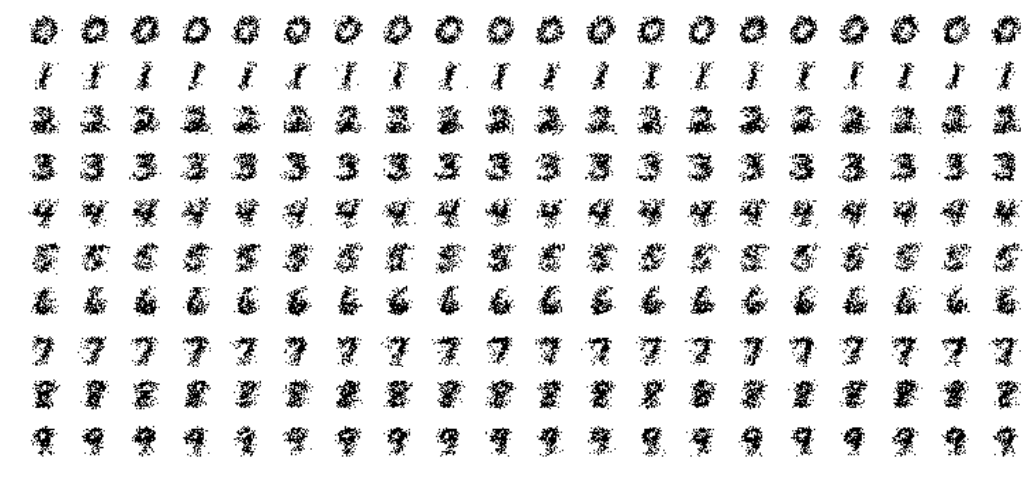

In [281]:
def P10(num_examples):
    '''Function that outputs generated images of numbers based on the MNIST data. Outputs sample images
    for each number equal to the number of examples.'''
    #Create copy of the mini train data
    bnb_train_data = np.copy(mini_train_data)
    #Binarize the data
    for i in range(len(bnb_train_data)):
        for x in range(len(bnb_train_data[i])):
            if bnb_train_data[i][x] > 0:
                bnb_train_data[i][x] = 1
            else:
                bnb_train_data[i][x] = 0
    # Fit bernoulli naive bayes with alpha = 0.01
    bnb = BernoulliNB(alpha = .01)
    bnb.fit(bnb_train_data, mini_train_labels)
    #Obtain the posterior probability matrix
    probs = np.exp(bnb.feature_log_prob_)
    ex_images = []
    # Create binarized arrays where images are colored in if they're value is greater than the posterior probability 
    # for that cell, and white otherwise. 
    for i in range(len(probs)):
        for j in range(num_examples):
            img = np.array([np.random.rand() for x in range(784)])
            for k in range(len(img)):
                if img[k] > probs[i][k]:
                    img[k] = 0
                else:
                    img[k] = 1
            ex_images.append(img.reshape(28,28))
    # Plot the series of images. 
    fig = plt.figure(figsize=(18, 8))
    for img in range(len(ex_images)):
        plt.subplot(10, num_examples, img+1)
        plt.axis('off')
        plt.imshow(ex_images[img], cmap='Greys')
    return
P10(20)

ANSWER: Just looking at the images, the Bernoulli naive bayes model has done a reasonable job of finding the pixels that tend to be colored in for each number. This gives the numeric part of each image a form that would be recognizable to people. At the edges of the image, the probabilistic nature of coloring in a cell results in a fair amount of random noise generated in the periphery. The amount of noise at the far periphery can be controlled using a lower alpha value, but in the immediate area of the image, there tends to be a lot of noise. Additionally, the fact that the pixel values become simplified to 0 or 1, the images are completely black or white in a way that none of the original images are. 

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [52]:
def P11(buckets, correct, total):
    '''Function that takes the posterior probabilities of a Bernoulli Naive Bayes model
    and evaluates the accuracy of the predictions based on the strength of the posterior probability.'''
    # Copy the mini_train_data and binarize data
    bnb_train_data = np.copy(mini_train_data)
    for i in range(len(bnb_train_data)):
        for x in range(len(bnb_train_data[i])):
            if bnb_train_data[i][x] > 0:
                bnb_train_data[i][x] = 1
            else:
                bnb_train_data[i][x] = 0
    # Fit Bernoulli Naive Bayes with alpha - 0.1
    bnb = BernoulliNB(alpha = 0.1)
    bnb.fit(bnb_train_data, mini_train_labels)
    for i in range(len(np.exp(bnb.predict_log_proba(dev_data)))):
        # Find the highest posterior probability, the index of this value is the predicted number. 
        prediction = np.where(
            np.exp(bnb.predict_log_proba(dev_data))[i] == max(np.exp(bnb.predict_log_proba(dev_data))[i]))[0][0]
        #Determine which bucket the posterior is in
        if max(np.exp(bnb.predict_log_proba(dev_data))[i]) == buckets[-1]:
            # Increment the total
            total[-1] += 1
            # Increment the correct if the prediction matches the label
            if prediction == dev_labels[i]:
                correct[-1]+= 1
        #Loop through each bucket group and do the same.
        elif buckets[-2] < max(np.exp(bnb.predict_log_proba(dev_data))[i]) < buckets[-1]:
            total[-2] += 1
            if prediction == dev_labels[i]:
                correct[-2]+= 1
        elif buckets[-3] < max(np.exp(bnb.predict_log_proba(dev_data))[i]) < buckets[-2]:
            total[-3] += 1
            if prediction == dev_labels[i]:
                correct[-3]+= 1
        elif buckets[-4] < max(np.exp(bnb.predict_log_proba(dev_data))[i]) < buckets[-3]:
            total[-4] += 1
            if prediction == dev_labels[i]:
                correct[-4]+= 1
        elif buckets[-5] < max(np.exp(bnb.predict_log_proba(dev_data))[i]) < buckets[-4]:
            total[-5] += 1
            if prediction == dev_labels[i]:
                correct[-5]+= 1
        elif buckets[-6] < max(np.exp(bnb.predict_log_proba(dev_data))[i]) < buckets[-5]:
            total[-6] += 1
            if prediction == dev_labels[i]:
                correct[-6]+= 1
        elif buckets[-7] < max(np.exp(bnb.predict_log_proba(dev_data))[i]) < buckets[-6]:
            total[-7] += 1
            if prediction == dev_labels[i]:
                correct[-7]+= 1
        elif buckets[-8] < max(np.exp(bnb.predict_log_proba(dev_data))[i]) < buckets[-7]:
            total[-8] += 1
            if prediction == dev_labels[i]:
                correct[-8]+= 1
        else:
            total[-9] += 1
            if prediction == dev_labels[i]:
                correct[-9]+= 1
    return 

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)
#Print the total and accuracy for predictions is each bucket. 
for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0):
        accuracy = correct[i]*1.0 / total[i]
        print 'p(pred) <= {}    total = {}   accuracy = {}'.format(buckets[i], total[i], round(accuracy,3))

p(pred) <= 0.5    total = 33   accuracy = 0.364
p(pred) <= 0.9    total = 71   accuracy = 0.493
p(pred) <= 0.999    total = 53   accuracy = 0.434
p(pred) <= 0.99999    total = 64   accuracy = 0.609
p(pred) <= 0.9999999    total = 46   accuracy = 0.543
p(pred) <= 0.999999999    total = 52   accuracy = 0.808
p(pred) <= 0.99999999999    total = 49   accuracy = 0.796
p(pred) <= 1.0    total = 18   accuracy = 0.722
p(pred) <= 1.0    total = 614   accuracy = 0.958


ANSWER: The Naive Bayes model shows a positive correlation between posterior probability and prediction accuracy. The model performs considerably better than chance, and thus would not be accurately described as a weak classifier. However, there is not a correspondence between the posterior probability and the actual accuracy of the classifier.

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!